In [21]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

En el caso de Madrid tenía casos para toda la CC.AA., pero en realidad sólo necesito para el municipio de Madrid. Por tanto importo la geometría del municipio y filtro sólo las observaciones que están en él. 

In [22]:
amb=pd.read_excel('G:/Mi unidad/Documentos personales/9-Documentos Doctorado/Doctorado 2023/11-Web scrapping/data/a-amb-marzo24.xlsx')
mad=pd.read_excel('G:/Mi unidad/Documentos personales/9-Documentos Doctorado/Doctorado 2023/11-Web scrapping/data/a-prov_mad-marzo24.xlsx')

#Le creo un ID
mad.reset_index(drop=True, inplace=True)
mad.index = mad.index + 1
mad.insert(0, 'ID', mad.index)

# Convertir el DataFrame a un GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in zip(mad['Lon_X'], mad['Lat_Y'])]
crs = 'epsg:4326'  # Definir sistema de coordenadas WGS84
gdf_puntos = gpd.GeoDataFrame(mad, crs=crs, geometry=geometry)
gdf_puntos = gdf_puntos.to_crs(epsg=32631)

geomad=gpd.read_file('G:/Mi unidad/Datos/españa/vectores/MUNICIPOS-ESPAÑA-31N.gpkg')
geomad=geomad[geomad['NAMEUNIT']=='Madrid']

munmad = gpd.sjoin(gdf_puntos, geomad[['geometry']], how='inner', predicate='intersects')
munmad=munmad.drop(['geometry','index_right'],axis=1)

In [23]:
print(len(mad))
print(len(munmad))

2405
1983


Creo una columna que me indique los quintiles a los que pertenece cada observación.

In [24]:
# Creas una nueva columna en cada DataFrame con los quintiles
amb['qprecio'] = pd.qcut(amb['precio_euros'], 5, labels=False)
munmad['qprecio'] = pd.qcut(munmad['precio_euros'], 5, labels=False)

In [25]:
len(amb)

2417

In [26]:
print(amb['qprecio'].unique())
print(munmad['qprecio'].unique())

[0 1 2 3 4]
[0 1 4 2 3]


In [27]:
print(len(amb[amb['qprecio']==0]))
print(len(amb[amb['qprecio']==1]))
print(len(amb[amb['qprecio']==2]))
print(len(amb[amb['qprecio']==3]))
print(len(amb[amb['qprecio']==4]))

517
467
468
489
476


Calculo la muestra aleatoria.

Como los quintiles dividen el dataframe en cinco partes iguales, cada una representa aproximadamente el 20% del total de datos. Por tanto, el tamaño de cada muestra por quintil debería ir entorno a la mitad de eso, el 10%. Inicialmente consideré esa cantidad pero como la coordinación con Carlos fue que cada estudiante tuviera alrededor de 300 muestras por revisar, podía subir el umbral hasta un 12.5%.

In [61]:
# Calcula el tamaño de muestra deseado para cada quintil
tamano_muestra_por_quintil = int(len(amb) * 0.125)  # 10% de la longitud total de amb

# Define una función para muestrear estratificadamente cada DataFrame
def muestreo_estratificado(df):
    # Realiza el muestreo estratificado por quintil
    muestra_estratificada = df.groupby('qprecio').apply(lambda x: x.sample(tamano_muestra_por_quintil, random_state=42))
    # Reinicia el índice
    muestra_estratificada.reset_index(drop=True, inplace=True)
    return muestra_estratificada

# Aplica la función a cada DataFrame
muestra_amb = muestreo_estratificado(amb)
len(muestra_amb)

1510

In [62]:
print(len(muestra_amb[muestra_amb['qprecio']==0]))
print(len(muestra_amb[muestra_amb['qprecio']==1]))
print(len(muestra_amb[muestra_amb['qprecio']==2]))
print(len(muestra_amb[muestra_amb['qprecio']==3]))
print(len(muestra_amb[muestra_amb['qprecio']==4]))

302
302
302
302
302


In [63]:
# Calcula el tamaño de muestra deseado para cada quintil
tamano_muestra_por_quintil = int(len(munmad) * 0.125)  # 10% de la longitud total de munmad

# Define una función para muestrear estratificadamente cada DataFrame
def muestreo_estratificado(df):
    # Realiza el muestreo estratificado por quintil
    muestra_estratificada = df.groupby('qprecio').apply(lambda x: x.sample(tamano_muestra_por_quintil, random_state=42))
    # Reinicia el índice
    muestra_estratificada.reset_index(drop=True, inplace=True)
    return muestra_estratificada

# Aplica la función a cada DataFrame
muestra_munmad = muestreo_estratificado(munmad)
len(muestra_munmad)

1235

In [64]:
print(len(muestra_munmad[muestra_munmad['qprecio']==0]))
print(len(muestra_munmad[muestra_munmad['qprecio']==1]))
print(len(muestra_munmad[muestra_munmad['qprecio']==2]))
print(len(muestra_munmad[muestra_munmad['qprecio']==3]))
print(len(muestra_munmad[muestra_munmad['qprecio']==4]))

247
247
247
247
247


Reviso la distribución tanto de los datos originales como de la muestra.

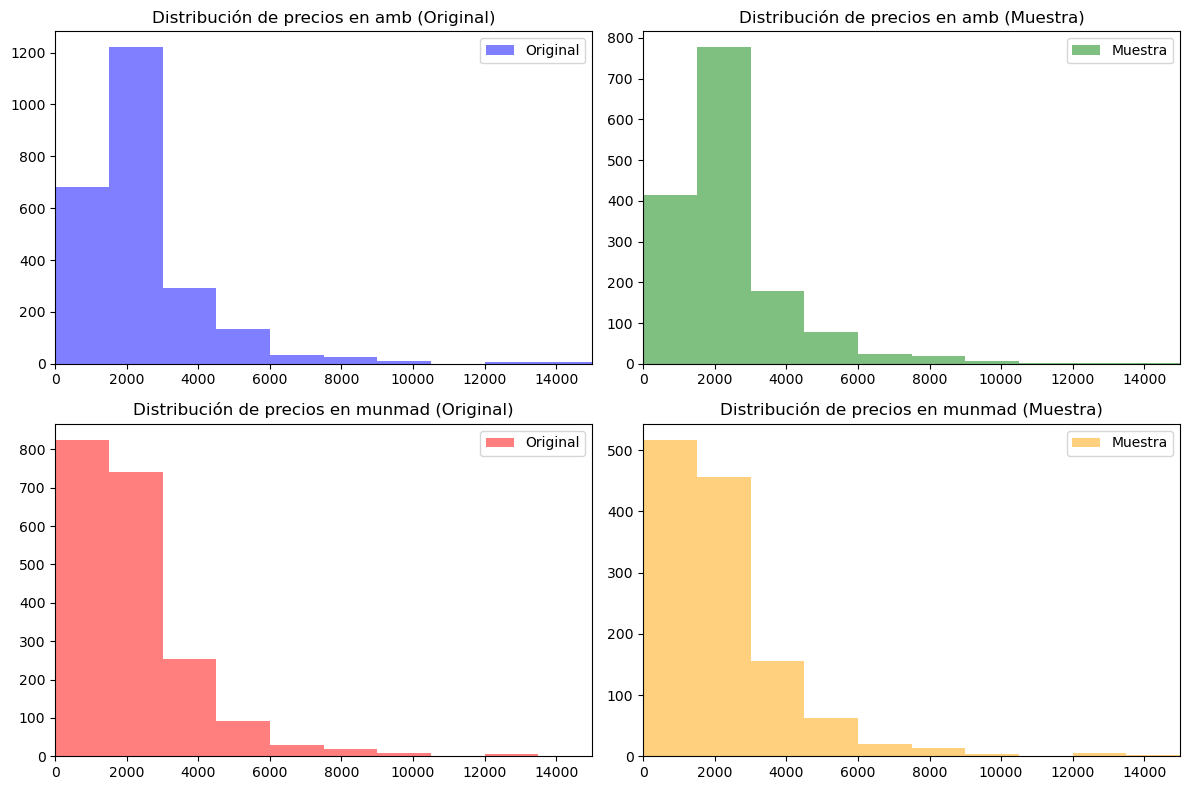

In [65]:
# Crear subgráficos para mostrar los histogramas
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Definir los límites y la separación del eje x
x_min = 0
x_max = 15000
bin_width = 1500
num_bins = int((x_max - x_min) / bin_width)

# Histograma de los datos originales de amb
axs[0, 0].hist(amb['precio_euros'], bins=np.arange(x_min, x_max + bin_width, bin_width), color='blue', alpha=0.5, label='Original')
axs[0, 0].set_title('Distribución de precios en amb (Original)')
axs[0, 0].legend()

# Histograma de los datos de la muestra de amb
axs[0, 1].hist(muestra_amb['precio_euros'], bins=np.arange(x_min, x_max + bin_width, bin_width), color='green', alpha=0.5, label='Muestra')
axs[0, 1].set_title('Distribución de precios en amb (Muestra)')
axs[0, 1].legend()

# Histograma de los datos originales de munmad
axs[1, 0].hist(munmad['precio_euros'], bins=np.arange(x_min, x_max + bin_width, bin_width), color='red', alpha=0.5, label='Original')
axs[1, 0].set_title('Distribución de precios en munmad (Original)')
axs[1, 0].legend()

# Histograma de los datos de la muestra de munmad
axs[1, 1].hist(muestra_munmad['precio_euros'], bins=np.arange(x_min, x_max + bin_width, bin_width), color='orange', alpha=0.5, label='Muestra')
axs[1, 1].set_title('Distribución de precios en munmad (Muestra)')
axs[1, 1].legend()

# Ajustar los límites del eje x
for ax in axs.flat:
    ax.set_xlim(x_min, x_max)

plt.tight_layout()
plt.show()

In [9]:
print(muestra_amb.columns.tolist())
print(muestra_munmad.columns.tolist())

['ID', 'Title', 'Link', 'precio_euros', 'codigo_inmueble', 'Description', 'last_mod', 'dummy_indice', 'indice_alquiler', 'area', 'n_rooms', 'price_m2', 'n_baths', 'n_aseo', 'laundry', 'buhardilla', 'despacho', 'trastero', 'terrace', 'kwhm2_year', 'kgCO2m2_year', 'dummy_consum_EPC', 'dummy_emission_EPC', 'consum_A', 'consum_B', 'consum_C', 'consum_D', 'consum_E', 'consum_F', 'consum_G', 'emission_A', 'emission_B', 'emission_C', 'emission_D', 'emission_E', 'emission_F', 'emission_G', 'AC', 'parking', 'pool', 'lift', 'furniture', 'public_transp', 'barrio', 'codigo_inmueble_numero', 'Lat_Y', 'Lon_X', 'multifam', 'atico', 'duplex', 'estudio', 'loft', 'piso', 'triplex', 'qprecio']
['ID', 'Title', 'Link', 'precio_euros', 'codigo_inmueble', 'Description', 'last_mod', 'dummy_indice', 'indice_alquiler', 'area', 'n_rooms', 'price_m2', 'n_baths', 'n_aseo', 'laundry', 'buhardilla', 'despacho', 'trastero', 'terrace', 'kwhm2_year', 'kgCO2m2_year', 'dummy_consum_EPC', 'dummy_emission_EPC', 'consum_A',

In [66]:
muestra_amb2=muestra_amb.drop(columns=['ID','qprecio'])
muestra_amb2['AMB']=1
muestra_amb2['MAD']=0

muestra_munmad2=muestra_amb.drop(columns=['ID','qprecio'])
muestra_munmad2['AMB']=0
muestra_munmad2['MAD']=1

In [67]:
evatex = pd.concat([muestra_amb2, muestra_munmad2], ignore_index=True)

evatex.reset_index(drop=True, inplace=True)
evatex.index = evatex.index + 1
evatex.insert(0, 'ID', evatex.index)

Entre los estudiantes tendrían esta cantidad de muestras por revisar.

In [68]:
len(evatex)/10

302.0

In [69]:
evatex.to_excel("data/a-amb+mad-marzo24.xlsx", index=False)

En la muestra no hay inmuebles del tipo *triplex*. Voy a revisar cuántas observaciones de ese tipo hay en los df originales.

In [72]:
len(amb[amb['triplex']==1])

1

In [73]:
len(munmad[munmad['triplex']==1])

0

In [74]:
len(mad[mad['triplex']==1])

1